#  <center>Coursera Capstone: Battle of the neighbourhoods </center>

### <center> Finding the best neighbourhood in Mumbai to open a Thai restaurant </center>

<img src="Pad-Thai-in-Bangkok.jpg">

<font size="0.5">image credit: https://www.desiam.com/blogs/post/The-forgotten-history-of-Pad-Thai</font>







# 1. Introduction
This project is defined on the basis of available data on the city of Mumbai.

The metropolitan city of Mumbai is the most populous city in India and is also the financial capital of the country. It is a major economic hub, and with a touch of both, the rustic and modern elements, it attracts people from all over the world.

In a hypothetical scenario, a successful hotelier and owner of a chain of Asian restaurants called "Thai Jasmin", wishes to open another one, in India. This is his first restaurant in the country, and after several business visits, Mumbai seemed the most obvious choice due to its vibrancy and charm. It is not a cheap investment though, and hence he needs to be careful in his selection of a location in Mumbai: a non-trivial process.




### 1.1 Defining the problem

The idea behind this exercise is to find the best neighbourhood in Mumbai for the restaurant to run successfully and attract both foreigners as well as local residents. There are several factors to consider here, and some more that are out-of scope for this project, but should be considered nonetheless.

- Finding the most popular neighbourhoods based on all venues: Monuments, shopping places, restaurants etc.
- In these popular neighbourhoods, finding the highest density of restaurants
- And then narrowing down to the number of Thai restaurants

### 1.2 Other things to consider (out of scope due to lack of data)
- Commercial Rental prices: Whether within budget or not
- density of population around the location: Segregate residential population from non-residential
- etc


# 2. Methodology 



### 2.1 Importing libraries

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import urllib.request
from bs4 import BeautifulSoup
import geocoder
from geopy.geocoders import Nominatim
import numpy as np
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import io
from PIL import Image


import folium # map rendering library
%matplotlib inline

### 2.2  Read csv file containing coordinates. 

I scraped the table given on this website: https://www.mapsofindia.com/pincode/india/maharashtra/mumbai/ but I retrieved the coordinates of these locations through private communication. The two tables were merged already and hence here I directly load the .csv file.

In [2]:
df_mumnew= pd.read_csv('Mumbai-Mumbaipins_all.csv')

df_mumnew.count()


Location     173
Pincode      173
State        173
District     173
Latitude     173
Longitude    173
dtype: int64

### 2.3  Use geolocator to calculate the coordinates of Mumbai.

In [3]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

#latitude = 18.9387711
#longitude=72.8353355

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.


### 2.4 First visualise our Mumbai dataset using Folium

It is always nice to see what kind of data we're working with. Here, we see that the file contains neighbourhoods that cover most of Mumbai. The colours have been assigned randomly.

In [4]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(len(df_mumnew.index))
ys = [i + x + (i*x)**2 for i in range(len(df_mumnew.index))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

length=len(df_mumnew.index)
#colors = cm.rainbow(np.linspace(0, 1, length))
#print(colors)
rainbow = [colors.rgb2hex(i) for i in colors_array]


zipped=zip(df_mumnew['Location'], df_mumnew['District'], df_mumnew['Latitude'], df_mumnew['Longitude'],rainbow)
for i,dat in enumerate(zipped):
    plname,city,lat, lng,cl = dat

    label = '{}, {}'.format(plname,city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[i], #'black',
        fill=True,
        fill_color= rainbow[i],#'pink',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum


### 2.5 The Foursquare API

First, we define functions that can read the JSON files returned by Foursquare and return a dataframe with columns that are of use to us for this exercise.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        fs_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(fs_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['stats']['checkinsCount']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue  Check-in']
    
    return(nearby_venues)

Next, we provide the credentials required by Foursquare. During final submission of this notebook, these details will be hidden.

In [ ]:
CLIENT_ID = '# your Foursquare ID' 
CLIENT_SECRET = '# your Foursquare Secret' # your Foursquare Secret
VERSION = '20140715' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 100 # define radius

For every neighbourhood in our dataframe, we now can use the Foursquare API to collect venue information within a 1 km radius. Note that more information on each venue is available in the premium version of Foursquare. Such information is useful in narrowing down our search, but we work without it in this exercise.
The Foursquare data is collected using a pre-defined function called "getNearbyVenues", which makes the request, collects relevant data from the returned .json file and converts it to a dataframe.



In [11]:
mumbai_venues = getNearbyVenues(names=df_mumnew['Location'],
                                   latitudes=df_mumnew['Latitude'],
                                   longitudes=df_mumnew['Longitude']
                                  )



A I staff colony
Aareymilk Colony
Agripada
Airport
Ambewadi
Andheri
Andheri East
Andheri Railway station
Antop Hill
Anushaktinagar
Asvini
Azad Nagar
B P t colony
B.N. bhavan
B.P.lane
Bandra West
Bandra(east)
Bangur Nagar
Bazargate
Best Staff colony
Bhawani Shankar
Borivali
Borivali East
Borvali West
C G s colony
Central Building
Century Mill
Chakala Midc
Chamarbaug
Charkop
Charni Road
Chaupati
Chembur
Chembur Rs
Chinchbunder
Chinchpokli
Chowpatty
Churchgate
Colaba
Cotton Exchange
Cumballa Hill
Dadar
Dahisar
Danda
Daulat Nagar
Delisle Road
Dharavi
Dockyard Road
Dr Deshmukh marg
Falkland Road
Ghatkopar
Girgaon
Gokhale Road
Goregaon
Goregaon East
Govandi
Government Colony
Gowalia Tank
Grant Road
H.M.p. school
Haffkin Institute
Haines Road
Hajiali
Hanuman Road
High Court bulding
Holiday Camp
Irla
Ins Hamla
International Airport
J.B. nagar
J.J.hospital
Jacob Circle
Jogeshwari East
Jogeshwari West
Juhu
Kalachowki
Kalbadevi
Kamathipura
Kandivali East
Kandivali West
Kapad Bazar
Ketkipada
Khar 

On checking the newly generated dataframe mumbai_venues, we see all the relevant information on the venues returned for each neighbourhood, such as their coordinates, name and category. Note that the Venue Check-in column doesn't have any useful information, so we don't use it for our analysis.

In [12]:
mumbai_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Check-in
0,A I staff colony,19.07870,72.86005,Natural's Ice Cream,19.077560,72.863035,Ice Cream Shop,0
1,A I staff colony,19.07870,72.86005,Nilesh Dry Fruits,19.077578,72.864080,Food & Drink Shop,0
2,A I staff colony,19.07870,72.86005,Monginis,19.077565,72.860089,Bakery,0
3,A I staff colony,19.07870,72.86005,Kalina bus stop,19.076665,72.862189,Bus Station,0
4,A I staff colony,19.07870,72.86005,Laxmi Chemist & Druggist,19.076668,72.862224,Pharmacy,0
5,A I staff colony,19.07870,72.86005,SONY CENTRE,19.077760,72.864600,Electronics Store,0
6,Agripada,18.98481,72.81686,Gallops,18.981231,72.817178,Restaurant,0
7,Agripada,18.98481,72.81686,Little Italy,18.983885,72.815241,Italian Restaurant,0
8,Agripada,18.98481,72.81686,Nehru Centre Art Gallery,18.988617,72.814981,Art Gallery,0
9,Agripada,18.98481,72.81686,Nehru Auditorium,18.988726,72.814814,Theater,0


In [13]:
mumbai_venues['Venue Category'][:10]

0        Ice Cream Shop
1     Food & Drink Shop
2                Bakery
3           Bus Station
4              Pharmacy
5     Electronics Store
6            Restaurant
7    Italian Restaurant
8           Art Gallery
9               Theater
Name: Venue Category, dtype: object

Now, we see that not all venue categories are unique. There are some differences in the tags, for venues belonging to the same category. For example, coffee shops and cafes are the same thing. Similarly, to make things easier, we'll club "Pizza places" with "italian restaurants", Chinese/noodle houses with "Asian restaurants" etc. Here are some of the most obvious once, after a quick look at the venue categories.


In [14]:
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Coffee Shop', 'Venue Category'] = 'Café'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Tea Room', 'Venue Category'] = 'Café'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Chinese Restaurant', 'Venue Category'] = 'Asian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Japanese Restaurant', 'Venue Category'] = 'Asian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Thai Restaurant', 'Venue Category'] = 'Asian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Noodle House', 'Venue Category'] = 'Asian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Pizza Place', 'Venue Category'] = 'Italian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Mediterranean Restaurant', 'Venue Category'] = 'Italian Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Cupcake Shop', 'Venue Category'] = 'Bakery'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Snack Place', 'Venue Category'] = 'Fast Food Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Food & Drink Shop', 'Venue Category'] = 'Department Store'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Bar', 'Venue Category'] = 'Pub'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Beer Garden', 'Venue Category'] = 'Pub'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Beer Bar', 'Venue Category'] = 'Pub'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Indie Movie Theater', 'Venue Category'] = 'Theatre/Multiplex'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Movie Theater', 'Venue Category'] = 'Theatre/Multiplex'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Theater', 'Venue Category'] = 'Theatre/Multiplex'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Multiplex', 'Venue Category'] = 'Theatre/Multiplex'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Gym', 'Venue Category'] = 'Gym / Fitness Center'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Garden Center', 'Venue Category'] = 'Garden'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Park', 'Venue Category'] = 'Garden'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Sports Club', 'Venue Category'] = 'Athletics & Sports'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Diner', 'Venue Category'] = 'Hotel'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Comfort Food Restaurant', 'Venue Category'] = 'Fast Food Restaurant'
mumbai_venues.loc[mumbai_venues['Venue Category'] == 'Plaza', 'Venue Category'] = 'Shopping Mall'


Save to csv, in case data collection from Foursquare becomes difficult (due to connectivity issues)

In [15]:
mumbai_venues.to_csv ('mumbai_venues.csv', index = False, header=True)
#mumbai_venues= pd.read_csv('mumbai_venues.csv')

Subsequently, just to familiarise ourselves with the various venues we now have, we'll look at which venues are most popular in all of Mumbai

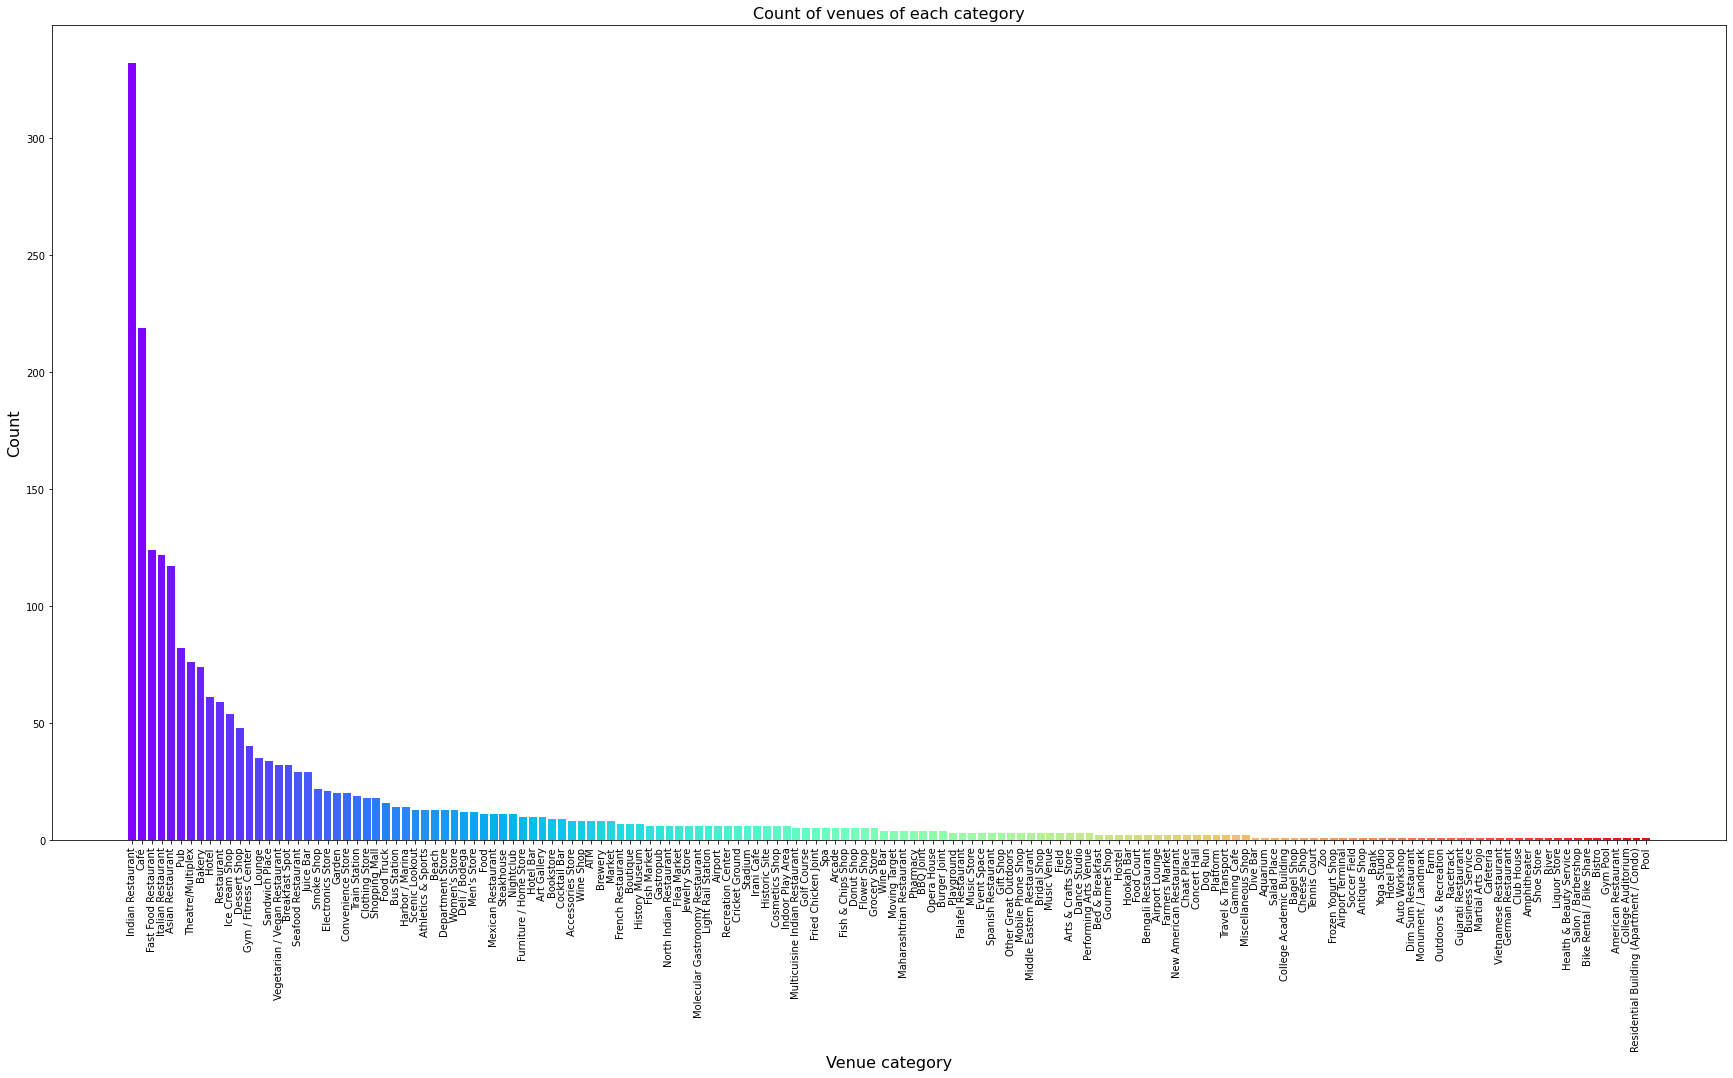

In [16]:
venue_distribution = mumbai_venues['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (30,15))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)
plt.savefig("allvenues.png")

Here, we see that Indian restaurants are most popular, followed by cafes, fast food restaurants, Italian restaurants and then Asian restaurants, which we are interested in opening.

Next, we look at which neighbourhoods have the maximum venues.

In [17]:
numv=pd.DataFrame(mumbai_venues.groupby('Neighborhood').count()).reset_index()
numv.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Check-in
0,A I staff colony,6,6,6,6,6,6,6
1,Agripada,13,13,13,13,13,13,13
2,Airport,4,4,4,4,4,4,4
3,Ambewadi,3,3,3,3,3,3,3
4,Andheri,16,16,16,16,16,16,16


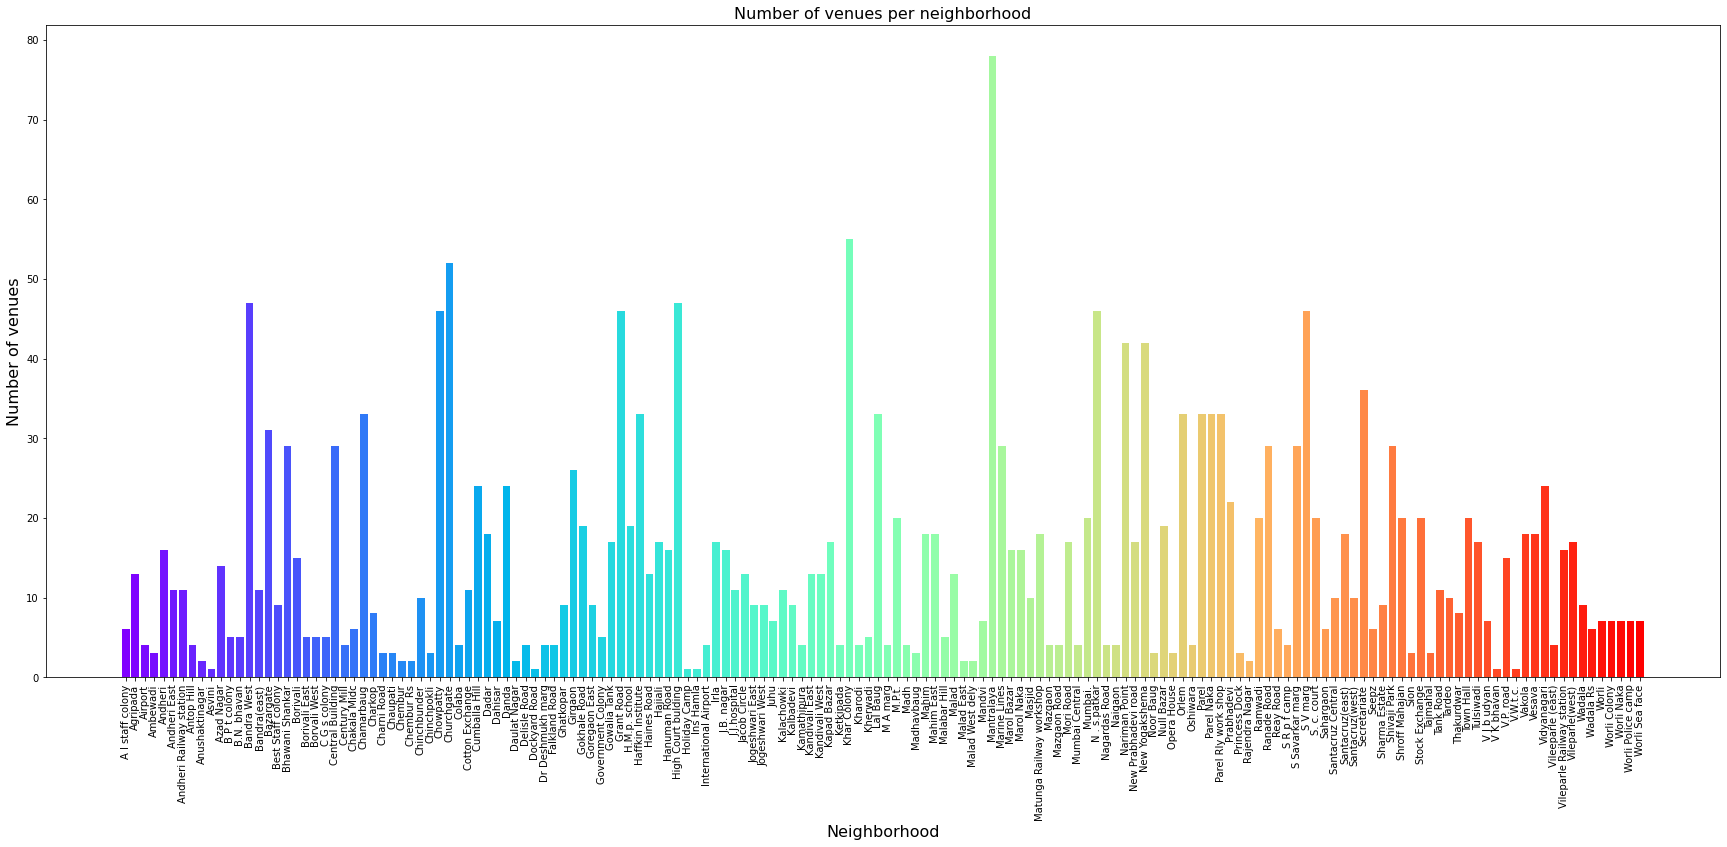

In [18]:
numvenues = numv['Venue Category']
nei=numv['Neighborhood']
colors = cm.rainbow(np.linspace(0, 1, len(numvenues.index)))
plt.figure(figsize = (30, 12))
plt.xticks(rotation = 90)
plt.xlabel("Neighborhood", fontsize = 16)
plt.ylabel("Number of venues", fontsize = 16)
plt.title("Number of venues per neighborhood", fontsize = 16)
plt.bar(nei,numvenues, color = colors)
plt.savefig("maxvenues.png")

We see in the plot above that some neighbourhoods in Mumbai have more than 40 venues/places of interest. Since we're interested in having our restaurant located in a popular and highly visited neighbourhood, we discard those neighbourhoods that have less than 10 venues. This narrows down our search criteria considerably.

### 2.6 Data wrangling

Now, let's combine the information from this filtered venue table with the original table containing the neighbourhoods and geographical coordinates. 

In [19]:
filt_mum = numv.loc[numv['Venue Category']>10.0].copy()
filt_mum.drop(filt_mum.columns[[1, 2, 3, 4, 5, 6, 7]], axis = 1, inplace = True)

mum_ven2=filt_mum.merge(mumbai_venues,left_on=['Neighborhood'], right_on=['Neighborhood'], how='left')
mum_ven2.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Check-in
0,Agripada,18.98481,72.81686,Gallops,18.981231,72.817178,Restaurant,0
1,Agripada,18.98481,72.81686,Little Italy,18.983885,72.815241,Italian Restaurant,0
2,Agripada,18.98481,72.81686,Nehru Centre Art Gallery,18.988617,72.814981,Art Gallery,0
3,Agripada,18.98481,72.81686,Nehru Auditorium,18.988726,72.814814,Theatre/Multiplex,0
4,Agripada,18.98481,72.81686,Viceroy @ NSCI,18.984465,72.815192,Restaurant,0


Next, using one hot encoding, we convert all string entries into numbers, so that we can then perform some statistical analyses and make some predictions using our data. While performing k-means clustering, I wanted the algorithm to also include the geographical coordinates along with other venue information in the clusters. 

In [20]:

# one hot encoding
mum_onehot = pd.get_dummies(mum_ven2[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
mum_onehot['Neighborhood'] = mum_ven2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mum_onehot.columns[-1]] + list(mum_onehot.columns[:-1])
mum_onehot = mum_onehot[fixed_columns]

mum_onehot_cl=mum_onehot.copy()

mum_onehot_cl['Venue Latitude'] = mum_ven2['Neighborhood Latitude']
mum_onehot_cl['Venue Longitude'] = mum_ven2['Neighborhood Longitude']


fixed_columns2 = [mum_onehot_cl.columns[-1]] + list(mum_onehot_cl.columns[:-1])
mum_onehot_cl = mum_onehot_cl[fixed_columns2]

fixed_columns3 = [mum_onehot_cl.columns[-1]] + list(mum_onehot_cl.columns[:-1])
mum_onehot_cl = mum_onehot_cl[fixed_columns3]



mum_onehot.head()


,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Beach,Bed & Breakfast,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Station,Cafeteria,Café,Chaat Place,Clothing Store,Cocktail Bar,College Academic Building,College Auditorium,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gujarati Restaurant,Gym / Fitness Center,Harbor / Marina,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irani Cafe,Italian Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Maharashtrian Restaurant,Market,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moving Target,Multicuisine Indian Restaurant,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Opera House,Other Great Outdoors,Outdoors & Recreation,Performing Arts Venue,Pharmacy,Platform,Playground,Pool,Pub,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Spa,Stadium,Steakhouse,Tennis Court,Theatre/Multiplex,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agripada,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The dataframe below is the one that we use for the clustering, which also contains spatial (Lat, Long) information. The one above will be used to return the most common venues for each neighbourhood. These are two different tables since if we provided spatial data to find the most common venues, the coordinates are considered as one of the venues (confusing!). 

In [21]:
mum_onehot_cl.head(5)

,Venue Latitude,Venue Longitude,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Beach,Bed & Breakfast,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Station,Cafeteria,Café,Chaat Place,Clothing Store,Cocktail Bar,College Academic Building,College Auditorium,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gujarati Restaurant,Gym / Fitness Center,Harbor / Marina,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irani Cafe,Italian Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Maharashtrian Restaurant,Market,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moving Target,Multicuisine Indian Restaurant,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Opera House,Other Great Outdoors,Outdoors & Recreation,Performing Arts Venue,Pharmacy,Platform,Playground,Pool,Pub,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Spa,Stadium,Steakhouse,Tennis Court,Theatre/Multiplex,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,18.98481,72.81686,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18.98481,72.81686,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18.98481,72.81686,Agripada,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,18.98481,72.81686,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,18.98481,72.81686,Agripada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
mum_grouped = mum_onehot.groupby('Neighborhood').mean().reset_index()
mum_grouped_cl=mum_onehot_cl.groupby('Neighborhood').mean().reset_index()


In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Here, we're making another table that will be combined with our cluster results, which will tell us which venues are the most common ones in each location.

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agripada,Restaurant,Indian Restaurant,Art Gallery,Golf Course,Theatre/Multiplex,Lounge,Hotel,Smoke Shop,Stadium,Italian Restaurant
1,Andheri,Indian Restaurant,Pub,Café,Nightclub,Bagel Shop,Fast Food Restaurant,Women's Store,Hotel Bar,Lounge,Farmers Market
2,Andheri East,Hotel Bar,Hotel,Indian Restaurant,Department Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint,Falafel Restaurant,Fast Food Restaurant
3,Andheri Railway station,Hotel Bar,Hotel,Indian Restaurant,Department Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint,Falafel Restaurant,Fast Food Restaurant
4,Azad Nagar,Juice Bar,Department Store,Italian Restaurant,Fish Market,Clothing Store,Residential Building (Apartment / Condo),Pub,Café,Women's Store,Convenience Store


### 2.7 Clustering 

Now we are ready to proceed with the clustering. We'll use the table we created earlier which also contains spatial information. We first need to figure out which value of "k" would best suit our data. For this purpose, we use the "elbow method".

In [25]:
mum_grouped_clustering = mum_grouped_cl.drop('Neighborhood', 1)
mum_grouped_clustering.columns

Index(['Venue Latitude', 'Venue Longitude', 'Accessories Store', 'Airport',
       'American Restaurant', 'Amphitheater', 'Antique Shop', 'Arcade',
       'Art Gallery', 'Arts & Crafts Store',
       ...
       'Tennis Court', 'Theatre/Multiplex', 'Train Station',
       'Travel & Transport', 'Vegetarian / Vegan Restaurant',
       'Vietnamese Restaurant', 'Wine Bar', 'Wine Shop', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=135)

In [26]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(mum_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

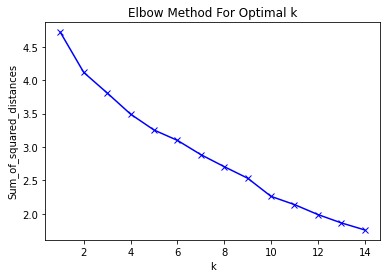

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
plt.savefig("elbow.png")

The figure shows an exponential decrease in the SSD as a function of k, so it is quite a challenge to know which k is best. On a closer look, it seems like there is a slight wiggle in the plot at k = 8 and probably also at k = 3, either of which could be considered the so-called "elbow". For now, we choose k=8 for our analysis.

In [28]:
# set number of clusters
kclusters = 8


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(mum_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([6, 5, 4, 4, 4, 0, 5, 5, 2, 1, 5, 5, 0, 0, 5, 0, 2, 0, 0, 7, 0, 0,
       2, 5, 6, 0, 4, 0, 0, 1, 0, 6, 5, 7, 7, 3, 5, 5, 0, 3, 3, 7, 0, 5,
       1, 1, 2, 3, 0, 0, 0, 5, 0, 5, 1, 5, 5, 5, 5, 0, 2, 2, 0, 0, 1, 0,
       2, 0, 0, 5, 0, 0, 1, 1, 3, 4, 4, 0], dtype=int32)

Now that we have 8 clusters based on the venues and geographical coordinates, we'll merge this information with our pre-existing dataframe:

In [29]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [30]:
mum_merged = df_mumnew

mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Location')


#delhi_merged[''] = delhi_merged['Cluster Labels'].apply(np.int64)
 # check the last columns!

mum_merged = mum_merged[mum_merged['Cluster Labels'].notna()]
mum_merged = mum_merged.astype({'Cluster Labels': 'int'})



mum_merged.head()

,Location,Pincode,State,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Agripada,400011,Maharashtra,Mumbai,18.984810,72.816860,6,Restaurant,Indian Restaurant,Art Gallery,Golf Course,Theatre/Multiplex,Lounge,Hotel,Smoke Shop,Stadium,Italian Restaurant
5,Andheri,400053,Maharashtra,Mumbai,19.115525,72.835262,5,Indian Restaurant,Pub,Café,Nightclub,Bagel Shop,Fast Food Restaurant,Women's Store,Hotel Bar,Lounge,Farmers Market
6,Andheri East,400069,Maharashtra,Mumbai,19.113657,72.869722,4,Hotel Bar,Hotel,Indian Restaurant,Department Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint,Falafel Restaurant,Fast Food Restaurant
7,Andheri Railway station,400058,Maharashtra,Mumbai,19.113668,72.869711,4,Hotel Bar,Hotel,Indian Restaurant,Department Store,Vegetarian / Vegan Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint,Falafel Restaurant,Fast Food Restaurant
11,Azad Nagar,400053,Maharashtra,Mumbai,19.129000,72.826800,4,Juice Bar,Department Store,Italian Restaurant,Fish Market,Clothing Store,Residential Building (Apartment / Condo),Pub,Café,Women's Store,Convenience Store


# 3 Results

Great! Now let's visualise these clusters on the map. I've assigned 8 distinct colors for each cluster.
- Cluster 1 =  red
- Cluster 2 =  cyan
- Cluster 3 =  blue
- Cluster 4 =  green
- Cluster 5 =  pink
- Cluster 6 =  magenta
- Cluster 7 =  white
- Cluster 8 =  yellow


In [50]:
f=folium.Figure(width=1200, height=800)

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12,)
cl_col=['red','cyan','blue','green','pink','magenta','white','yellow','black','0.5']


# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Location'], mum_merged['Cluster Labels']):
    if cluster==0:
        cl=cl_col[0]
    elif cluster==1:
        cl=cl_col[1]
    elif cluster==2:
        cl=cl_col[2]
    elif cluster==3:
        cl=cl_col[3]
    elif cluster==4:
        cl=cl_col[4]
    elif cluster==5:
        cl=cl_col[5]
    elif cluster==6:
        cl=cl_col[6]
    elif cluster==7:
        cl=cl_col[7]
    
    
    if cluster==0:

        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color=cl,
            fill_opacity=0.7).add_to(map_clusters)

f.add_child(map_clusters)

### 3.1 Examine clusters

 So, it looks like the magenta cluster (cluster 1) is the biggest, with maximum number of venues. This tells us that the neighbourhoods clustered together here are the most popular ones. This will be our cluster of interest.
Let's look at the number and exact location of Asian Restaurants in this cluster.

In [42]:
clust1=mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust2=mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust3=mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust4=mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust5=mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust6=mum_merged.loc[mum_merged['Cluster Labels'] == 5, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust7=mum_merged.loc[mum_merged['Cluster Labels'] == 6, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()
clust8=mum_merged.loc[mum_merged['Cluster Labels'] == 7, mum_merged.columns[[0] + list(range(4, mum_merged.shape[1]))]].copy()








counts_cl1 = clust1['Location'].value_counts()
clust1

,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Bandra West,19.055240,72.830818,0,Pub,Indian Restaurant,Café,Asian Restaurant,Bakery,Italian Restaurant,Fast Food Restaurant,Gourmet Shop,Theatre/Multiplex,German Restaurant
36,Chowpatty,18.956350,72.815420,0,Indian Restaurant,Ice Cream Shop,Café,Fast Food Restaurant,Italian Restaurant,Juice Bar,Restaurant,Mexican Restaurant,Breakfast Spot,Beach
37,Churchgate,18.932255,72.826428,0,Hotel,Fast Food Restaurant,Ice Cream Shop,Italian Restaurant,Indian Restaurant,Café,Asian Restaurant,Theatre/Multiplex,Restaurant,Pub
40,Cumballa Hill,18.970505,72.805744,0,Bakery,Sandwich Place,Yoga Studio,Hotel,Racetrack,Other Great Outdoors,Men's Store,Italian Restaurant,Indian Restaurant,Garden
43,Danda,19.074707,72.825325,0,Italian Restaurant,Dessert Shop,Bakery,Café,Asian Restaurant,Salon / Barbershop,Middle Eastern Restaurant,Fast Food Restaurant,Lounge,Ice Cream Shop
51,Girgaon,18.955966,72.819045,0,Indian Restaurant,Café,Fast Food Restaurant,Juice Bar,Italian Restaurant,Ice Cream Shop,Bakery,Electronics Store,Breakfast Spot,Restaurant
57,Gowalia Tank,18.965970,72.810915,0,Café,Indian Restaurant,Concert Hall,Falafel Restaurant,Farmers Market,Pub,Brewery,Restaurant,Breakfast Spot,Italian Restaurant
58,Grant Road,18.956350,72.815420,0,Indian Restaurant,Ice Cream Shop,Café,Fast Food Restaurant,Italian Restaurant,Juice Bar,Restaurant,Mexican Restaurant,Breakfast Spot,Beach
62,Hajiali,18.977454,72.810920,0,Pub,Shopping Mall,Golf Course,Juice Bar,Italian Restaurant,Deli / Bodega,Indian Restaurant,Scenic Lookout,Ice Cream Shop,Fast Food Restaurant
64,High Court bulding,18.929380,72.827500,0,Café,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Theatre/Multiplex,Cricket Ground,Clothing Store,Italian Restaurant,Gym / Fitness Center,Field


Okay, How many Asian restaurants do we have and where?

In [43]:
var1="Asian Restaurant"
loc_asian=clust1[clust1.eq(var1).any(1)]
#clust1.head()
#clust1.filter(like='Asian Restaurant', axis=0)
loc_asian['Location']

15            Bandra West
37             Churchgate
43                  Danda
64     High Court bulding
88                 M.P.t.
98             Mantralaya
109               Mumbai.
114         Nariman Point
116        New Yogakshema
140          Secretariate
147        Stock Exchange
152             Town Hall
153             Tulsiwadi
Name: Location, dtype: object

In [44]:
clus1_merge_or = pd.DataFrame(clust1[['Location', 'Latitude', 'Longitude']])
clus1_merge_or = clus1_merge_or.rename(columns={'Location': 'Neighborhood', 'Latitude': 'Neighborhood Latitude', 'Longitude': 'Neighborhood Longitude'})

clus1_merge = pd.DataFrame(loc_asian[['Location', 'Latitude', 'Longitude']])
clus1_merge = clus1_merge.rename(columns={'Location': 'Neighborhood', 'Latitude': 'Neighborhood Latitude', 'Longitude': 'Neighborhood Longitude'})

clus1_merge1 = mum_ven2[mum_ven2.set_index(['Neighborhood']).index.isin(clus1_merge.set_index(['Neighborhood']).index)]
clus1_merge1_or = mum_ven2[mum_ven2.set_index(['Neighborhood']).index.isin(clus1_merge_or.set_index(['Neighborhood']).index)]
clus1_merge1_or.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Check-in
65,Bandra West,19.05524,72.830818,Godrej Nature's Basket,19.055509,72.831935,Gourmet Shop,0
66,Bandra West,19.05524,72.830818,IMBISS Meating Joint,19.053816,72.829851,German Restaurant,0
67,Bandra West,19.05524,72.830818,Nature's Basket,19.055533,72.831778,Gourmet Shop,0
68,Bandra West,19.05524,72.830818,Karachi sweets n chaat,19.055124,72.831499,Fast Food Restaurant,0
69,Bandra West,19.05524,72.830818,La Folie,19.055033,72.829260,Bakery,0


In [45]:
clus1_dum = mum_onehot_cl[mum_onehot_cl.set_index(['Neighborhood']).index.isin(clus1_merge.set_index(['Neighborhood']).index)]
#num=clus2_merge2.groupby('Neighborhood')['Venue Category'].nunique().reset_index()
num=clus1_merge1.loc[clus1_merge1['Venue Category']=='Asian Restaurant']
num

counts = num['Neighborhood'].value_counts()


counts

Mantralaya            6
High Court bulding    5
Bandra West           4
Secretariate          3
Churchgate            3
Tulsiwadi             3
Nariman Point         2
Town Hall             2
New Yogakshema        2
Mumbai.               2
Stock Exchange        2
Danda                 2
M.P.t.                2
Name: Neighborhood, dtype: int64

So these neighbourhoods are some of the most popular (not just within this cluster but in all of Mumbai!) but for the sake of exclusivity, we want to open the restaurant in a popular location not hosting any other Asian restaurant. Which locations are these?

In [46]:
df_diff = pd.concat([clus1_merge1_or,num]).drop_duplicates(keep=False)
df_diff.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Check-in
65,Bandra West,19.05524,72.830818,Godrej Nature's Basket,19.055509,72.831935,Gourmet Shop,0
66,Bandra West,19.05524,72.830818,IMBISS Meating Joint,19.053816,72.829851,German Restaurant,0
67,Bandra West,19.05524,72.830818,Nature's Basket,19.055533,72.831778,Gourmet Shop,0
68,Bandra West,19.05524,72.830818,Karachi sweets n chaat,19.055124,72.831499,Fast Food Restaurant,0
69,Bandra West,19.05524,72.830818,La Folie,19.055033,72.829260,Bakery,0


In [47]:
counts2 = df_diff['Neighborhood'].value_counts()
counts2

Mantralaya            72
Churchgate            49
N . s.patkar          46
S V marg              46
Chowpatty             46
Grant Road            46
Bandra West           43
High Court bulding    42
Nariman Point         40
New Yogakshema        40
Secretariate          33
Girgaon               26
Cumballa Hill         24
Danda                 22
Shroff Mahajan        20
Ramwadi               20
S. c. court           20
Town Hall             18
Mumbai.               18
M.P.t.                18
Stock Exchange        18
Vileparle(west)       17
Irla                  17
Hajiali               17
Gowalia Tank          17
Tulsiwadi             14
J.J.hospital          11
Name: Neighborhood, dtype: int64

Comparing the two neighbourhood columns, we find that NS Patkar, SV Marg, Chowpatty, Grant Road, Girgaon, Cumballa Hill, Shroff Mahajan, Ramwadi, S. c. court, Vile Parle West, Irla, Hajiali, Gowalia Tank and JJ hospital are the remainder neighbourhoods, in decreasing order of number of venues.

# 4 Conclusions

- NS Patkar, SV Marg, Chowpatty, Grant road and Girgaon are the top 5 locations to open an Asian (Thai restaurant) in a exclusive, yet popular place which has no other Asian restaurants within a search radius of 1 km.


- This conclusion is based on the largest cluster returned by the algorithm. Other clusters need to be examined further for any other conclusions to be drawn.


- This analysis is fairly limited since it does not take into account the commercial aspects such as the rent, menu price, income etc. More data is required for further analysis. Venue data can also be improved upon by using the premium version of Foursquare which is unavailable for this project.

- The choice of k can be tricky and needs to be looked at closely in order for the clustering to give the right results.

- One of the most important factors to consider is the accuracy of the dataset. During the analysis it was observed that some locations were extremely close to one another, which may cause overlap in the Foursquare venue data.